# Sistem Rekomendasi: MovieLens
## Nama: Hendratara Pratama
link dataset: [https://grouplens.org/datasets/movielens/](MovieLens)

## 1. Import Modul yang Diperlukan

In [1]:
# Proses Data Lib
import pandas as pd 
import numpy as np

# Visualisasi Data Lib
import matplotlib.pyplot as plt
import seaborn as sns

# Sistem Rekomendasi Lib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## 2. Menyiapkan Dataset

Dataset yang digunakan yaitu dataset rekomendasi film dari MovieLelens yang bisa ditemukan di [GroupLens](https://grouplens.org/datasets/movielens/)

In [2]:
!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ./datasets/movielens.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   157k      0  0:00:06  0:00:06 --:--:--  194k


Lalu Compress ZIP file data yang telah di download

In [3]:
!unzip ./datasets/movielens.zip -d ./datasets/

Archive:  ./datasets/movielens.zip
replace ./datasets/ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Melihat bentuk pohon dari _current work directory_

In [5]:
!tree

.
├── datasets
│   ├── ml-latest-small
│   │   ├── links.csv
│   │   ├── movies.csv
│   │   ├── ratings.csv
│   │   ├── README.txt
│   │   └── tags.csv
│   └── movielens.zip
├── images
│   └── top-10-tags.png
├── Main.ipynb
└── README.md

3 directories, 9 files


## 3. Data Understanding

Mebuat dataframe dari file 4 file dari MovieLens yang sudah di download lalu lihat panjang dari datanya

In [6]:
# Memuat semua dataset yang tersedia menjadi datafame
links_df = pd.read_csv('datasets/ml-latest-small/links.csv')
movies_df = pd.read_csv('datasets/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('datasets/ml-latest-small/ratings.csv')
tags_df = pd.read_csv('datasets/ml-latest-small/tags.csv')

# Melihat shape / ukuran dataframe
links_df.shape, movies_df.shape, ratings_df.shape, tags_df.shape

((9742, 3), (9742, 3), (100836, 4), (3683, 4))

Dataset berisi:
- tags.csv -> Semua peringkat terkandung dalam file ratings.csv. Setiap baris file ini setelah baris header mewakili satu peringkat dari satu film oleh satu pengguna, dan memiliki format berikut: userId,movieId,rating,timestamp.

- movies.csv -> Semua tag terkandung dalam file tags.csv. Setiap baris file ini setelah baris header mewakili satu tag yang diterapkan ke satu film oleh satu pengguna, dan memiliki format berikut: userId,movieId,tag,timestamp.

- ratings.csv -> Informasi film terkandung dalam file movies.csv. Setiap baris file ini setelah baris header mewakili satu film, dan memiliki format berikut: movieId,title,genres.

- tags.csv -> Pengidentifikasi yang dapat digunakan untuk menautkan ke sumber data film lainnya terdapat dalam file links.csv. Setiap baris file ini setelah baris header mewakili satu film, dan memiliki format berikut: movieId,imdbId,tmdbId.

Menampilkan summary dataframe links 

In [7]:
# Menampilkan summary links dataframe
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


Menampilkan summary dataframe movie

In [8]:
# Menampilkan summary movies dataframe
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Menampilkan summary dataframe ratings

In [9]:
# Menampilkan summary ratings dataframe
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Menampilkan summary dataframe tags

In [10]:
# Menampilkan summary tags dataframe
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Dari summary data diatas diketahui bahwa:
- userId -> ID pengguna yang telah dianonimkan | (int64)
- movieId -> movieId adalah pengidentifikasi untuk film yang digunakan oleh https://movielens.org. Misal film Toy Story memiliki link https://movielens.org/movies/1 | (int64)
- rating -> Peringkat dibuat dalam skala 5 bintang, dengan peningkatan setengah bintang (0,5 bintang - 5,0 bintang) | (float64)
- timestamp -> Stempel waktu mewakili detik sejak tengah malam Waktu Universal Terkoordinasi (UTC) tanggal 1 Januari 1970 | (int64)
- tag -> Metadata buatan dari pengguna tentang film | (object)
- title -> Judul film | (object)
- genres -> list genre pipe-separated | (object)
- imdbId -> imdbId adalah pengidentifikasi untuk film yang digunakan oleh http://www.imdb.com. Misalnya film Toy Story memiliki link http://www.imdb.com/title/tt0114709/ | (int64)
- tmdbId -> tmdbId adalah pengenal untuk film yang digunakan oleh https://www.themoviedb.org. Misal film Toy Story memiliki link https://www.themoviedb.org/movie/862 | (float64)

Menampilkan data 5 teratas dari dataframe links

In [11]:
# Menampilkan data 5 teratas links dataframe
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Menampilkan data 5 teratas dari dataframe movies

In [12]:
# Menampilkan data 5 teratas movies dataframe
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Menampilkan data 5 teratas dari dataframe ratings

In [13]:
# Menampilkan data 5 teratas ratings dataframe
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Menampilkan data 5 teratas dari dataframe tags

In [14]:
# Menampilkan data 5 teratas tags dataframe
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Melihat panjang data dari tag yang akan digunakan untuk content based filtering

In [15]:
# melihat unique dari tags
len(tags_df['tag'].unique())

1589

## 4. Data Preprocessing

Menggabungkan Movies dengan Tags berdasarkan MovieId
dan menampilkan 5 data teratas

In [16]:
# Menggabungkan Movies dengan Tags berdasarkan MovieId
tag_movies_df = movies_df.merge(tags_df, on='movieId', how='left')
tag_movies_df.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


Melihat total tag unik

In [17]:
# Melihat isi tags unique
len(tag_movies_df['tag'].unique().tolist())

1590

Melihat data kosong dari dataframe

In [18]:
# Melihat data not available / kosong
tag_movies_df.isna().sum()

movieId         0
title           0
genres          0
userId       8170
tag          8170
timestamp    8170
dtype: int64

menghapus movieId yang duplikat untuk digunakan.

In [19]:
# Membuang data duplikat
preparation = tag_movies_df.drop_duplicates('movieId')
preparation.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
3,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
7,3,Grumpier Old Men (1995),Comedy|Romance,289.0,moldy,1.143425e+09
9,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,NaN,NaN
10,5,Father of the Bride Part II (1995),Comedy,474.0,pregnancy,1.137374e+09


konversi series yang akan digunakan menjadi list lalu akan di cek panjang dari datanya

In [20]:
# Konversi series menjadi list
movie_id = preparation['movieId'].tolist()
title = preparation['title'].tolist()
tag = preparation['tag'].tolist()

len(movie_id), len(title), len(tag)

(9742, 9742, 9742)

Membuat daragrame baru dari list yang dibuat diatas

In [21]:
# Membuat Dataframe untuk data 'movie_id', 'title', 'tag'
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie': title,
    'tag': tag
})
movie_new.sample(5)

,id,movie,tag
4532,6718,Gotcha! (1985),NaN
5609,27008,From Dusk Till Dawn 2: Texas Blood Money (1999),NaN
3665,5047,Kung Pow: Enter the Fist (2002),NaN
4237,6178,"Patch of Blue, A (1965)",blind
7692,89678,Northanger Abbey (2007),NaN


Cek missing value pada dataframe yang baru dibuat

In [22]:
# Cek missing Value
movie_new.isna().sum(), len(movie_new)

(id          0
 movie       0
 tag      8170
 dtype: int64,
 9742)

Fill missing value dengan `UnkNown` tag

In [23]:
# Mengganti Tag yang tidak ada dengan unknown
movie_new.fillna('UnkNown', inplace=True)
movie_new.sample(5)

,id,movie,tag
3066,4115,Hiding Out (1987),UnkNown
5979,36477,"Baxter, The (2005)",UnkNown
3720,5139,"Bad News Bears, The (1976)",baseball
3615,4964,Baran (2001),UnkNown
1596,2138,Watership Down (1978),atmospheric


Menampilkan bar chart dari 10 tag terbanyak (kecuali ta `UnkNown`)

<Axes: >

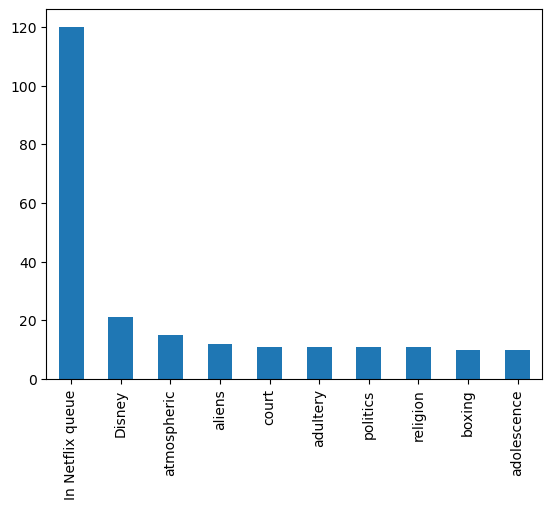

In [24]:
# bar chart 10 tag terbanyak
movie_new['tag'].value_counts()[1:11].plot(kind='bar')

## 5. Data Preparation

### Untuk Content Based Filtering

Untuk content based fiiltering digunakan tfidf sebelum diproses sebelum modelling

In [25]:
# Inisialisasi Tfidf Vectorizer
tfidf = TfidfVectorizer()

# Transform Matrix hasil dari TFIDF
tfidf_matrix = tfidf.fit_transform(movie_new['tag']).todense()
tfidf_matrix.shape

(9742, 904)

List tag yang diolah leh tfidf vectorizer

In [26]:
# List Tags
tfidf.get_feature_names_out()

array(['06', '1900s', '1920s', '1950s', '1960s', '1970s', '1980s', '2001',
       '2d', '70mm', '80', 'aardman', 'abortion', 'about', 'absorbing',
       'abstract', 'abuse', 'academy', 'accident', 'acting', 'action',
       'actress', 'adam', 'adams', 'addiction', 'adolescence', 'adoption',
       'adorable', 'adrien', 'ads', 'adult', 'adultery', 'adventure',
       'affleck', 'afghanistan', 'africa', 'agatha', 'aging', 'aids',
       'al', 'alcatraz', 'alcoholism', 'alcott', 'alfred', 'aliens',
       'allegorical', 'alone', 'alter', 'alternate', 'am', 'amazing',
       'america', 'american', 'amish', 'amnesia', 'amtrak', 'amy',
       'ancient', 'and', 'andrew', 'android', 'andy', 'animal',
       'animation', 'anime', 'anne', 'annoying', 'anthony', 'anti',
       'apocalypse', 'apocalyptic', 'appealing', 'aquarium',
       'archaeology', 'art', 'arthur', 'artificial', 'artistic', 'arts',
       'artsy', 'artwork', 'as', 'assassin', 'assassination', 'astaire',
       'asylum', 'at',

Membuat dataframe hasil dari tfidf dengan tag sebagai kolom dan index 

In [27]:
# Membuat DataFrame hasil tfidf
df = pd.DataFrame(tfidf_matrix,
                  columns=tfidf.get_feature_names_out(), 
                  index=movie_new['movie'])
df.sample(5)

,06,1900s,1920s,1950s,1960s,1970s,1980s,2001,2d,70mm,...,wine,with,without,world,writing,york,you,your,zombie,zombies
movie,,,,,,,,,,,,,,,,,,,,,
Stuart Little 3: Call of the Wild (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Sorry, Wrong Number (1948)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
People Will Talk (1951),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old Boy (2003),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Chorus, The (Choristes, Les) (2004)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Untuk Collaborative Filtering

Untuk collaborative filtering akan dilakukan dengan user-based, dataset yang digunakan yaitu movies dan ratings

In [28]:
# Menyiapkan Rating movie dataframe
rating_movie_df = movies_df.merge(ratings_df, on='movieId', how='left')
rating_movie_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


Cek missing value pada dataframe tersebut

In [29]:
# Cek Missing Value
rating_movie_df.isna().sum()

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64

menghapus missing value pada dataframe

In [30]:
# Menghapus Missing Value
rating_movie_df.dropna(inplace=True)

Membuang fitur `genres` dan `timestamp`

In [31]:
# Membuang data yg tidak diperlukan
rating_movie_df.drop(['genres', 'timestamp'], axis=1, inplace=True)

rating_movie_df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1.0,4.0
1,1,Toy Story (1995),5.0,4.0
2,1,Toy Story (1995),7.0,4.5
3,1,Toy Story (1995),15.0,2.5
4,1,Toy Story (1995),17.0,4.5


## 7. Modelling

### Dengan Cosine Similarity

Membuat variable cosine similarity dari hasil tfidf diatas

In [32]:
# Menghitung cosine similarity 
cosine_sim = cosine_similarity(np.array(tfidf_matrix)) 
cosine_sim, cosine_sim.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]),
 (9742, 9742))

Membuat dataframe baru dari hasil cosine similarity dengan movie sebagai index dan kolom

In [33]:
# Membuat Dataframe dari cosine similarity dengan baris dan kolom beruma movies
cosine_sim_df = pd.DataFrame(cosine_sim, 
                             index=movie_new['movie'], 
                             columns=movie_new['movie'])
cosine_sim_df.sample(5)

movie,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
movie,,,,,,,,,,,,,,,,,,,,,
Exam (2009),0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Sex and Lucia (Lucía y el sexo) (2001),0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Miss Meadows (2014),0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Mom and Dad Save the World (1992),0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Wild Bunch, The (1969)",0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Membuat fungsi untuk rekomendasi content based filtering

In [34]:
# Fungsi Mendapatkan Rekomendasi
def get_recommendation_cosine(nama_movie, similarity_data=cosine_sim_df, items=movie_new[['movie', 'tag']], k=10):
    # Mengambil data dengan menggunakan argpartition 
    # untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_movie agar yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movie, errors='ignore')
    
    return pd.DataFrame(closest).merge(items.reset_index(drop=True)).head(k)

Mendapatkan rekomendasi dari `Gintama: The Movie (2010)`

In [35]:
# Pemanggilan fungsi rekomendasi dengan Cosine similarity
get_recommendation_cosine('Gintama: The Movie (2010)')

,movie,tag
0,Princess Mononoke (Mononoke-hime) (1997),anime
1,Tekkonkinkreet (Tekkon kinkurîto) (2006),anime
2,Kiki's Delivery Service (Majo no takkyûbin) (1...,anime
3,My Neighbor Totoro (Tonari no Totoro) (1988),anime
4,Neon Genesis Evangelion: The End of Evangelion...,anime
5,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,anime
6,Howl's Moving Castle (Hauru no ugoku shiro) (2...,anime
7,Spirited Away (Sen to Chihiro no kamikakushi) ...,anime
8,Lost and Delirious (2001),UnkNown
9,Kiss of the Dragon (2001),UnkNown


### Dengan KNN

Menginisialisasi model NearestNeighbors dengan metric `euclidean` dan melakukan fitting untuk collaborative filtering

In [36]:
# Inisialisasi Model
knn = NearestNeighbors(metric='euclidean')

# Fitting Data
knn.fit(rating_movie_df.drop(['title', 'movieId'], axis=1))

NearestNeighbors(metric='euclidean')

Membuat fungsi rekomendasi dengan KNN

In [187]:
def get_recommendation_knn(nama_movie, top_n=10,data=rating_movie_df):
    # Mengambil ID dari items
    row = data[data['title'] == nama_movie]
    movie_id = row.index.values[0]
    inputan = data.drop(['title', 'movieId'], axis=1).loc[movie_id].values.reshape(1, -1)
    
    # Mencari nilai terdekat (index rating)
    distances, neighbors = knn.kneighbors(inputan,
                                          n_neighbors=top_n)
    # Return Similiar Movie
    output = pd.DataFrame(data.loc[neighbors[0], :])
    output['distance'] = distances[0]
    return output.merge(movie_new, left_on='title', right_on='movie', how='left').drop(['id', 'movie'], axis=1)

Mendapatkan rekomendasi `Gintama: The Movie (2010)` dari model KNN

In [188]:
get_recommendation_knn("Gintama: The Movie (2010)")

/home/tara/Projects/Python/machine-learning-monorepo/env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,movieId,title,userId,rating,distance,tag
0,70334,Hannah Montana: The Movie (2009),232.0,3.5,0.0,UnkNown
1,175303,It (2017),306.0,4.0,0.0,UnkNown
2,161131,War Dogs (2016),125.0,3.5,0.0,UnkNown
3,157296,Finding Dory (2016),610.0,4.0,0.0,UnkNown
4,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,154.0,5.0,0.0,Everything you want is here
5,101962,Wolf Children (Okami kodomo no ame to yuki) (2...,509.0,3.0,0.0,UnkNown
6,162600,Miss Peregrine's Home for Peculiar Children (2...,233.0,1.5,0.0,UnkNown
7,3793,X-Men (2000),172.0,3.5,0.0,action
8,5388,Insomnia (2002),80.0,4.0,0.0,Al Pacino
9,189111,Spiral (2018),338.0,3.0,0.0,UnkNown


## 8. Evaluasi

Membuat evaluasi metrik precision

In [134]:
# Fungsi untuk menghitung nilai presisi dari sistem rekomendasi
def precision(inputan, hasil_rec):
    relevant = 0
    for result in hasil_rec['tag'].values.tolist():
        if inputan['tag'] == result.lower():
            relevant += 1
    return relevant / len(hasil_rec)

Membuat variable film untuk dilakukan evaluasi metrik

In [117]:
# Input Evaluasi
input_movie = movie_new.loc[10]
input_movie

id                                   11
movie    American President, The (1995)
tag                            politics
Name: 10, dtype: object

### Evaluasi KNN

Mendapatkan rekomendasi dari `American President, The (1995)` dengan KNN

In [189]:
# Rekomendasi KNN
recommendation_knn = get_recommendation_knn(input_movie['movie'])
recommendation_knn

/home/tara/Projects/Python/machine-learning-monorepo/env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,movieId,title,userId,rating,distance,tag
0,7,Sabrina (1995),6.0,4.0,0.0,remake
1,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),6.0,4.0,0.0,time travel
2,16,Casino (1995),6.0,4.0,0.0,Mafia
3,34,Babe (1995),6.0,4.0,0.0,Animal movie
4,11,"American President, The (1995)",6.0,4.0,0.0,politics
5,317,"Santa Clause, The (1994)",6.0,4.0,0.0,Christmas
6,17,Sense and Sensibility (1995),6.0,4.0,0.0,Jane Austen
7,2,Jumanji (1995),6.0,4.0,0.0,fantasy
8,6,Heat (1995),6.0,4.0,0.0,UnkNown
9,261,Little Women (1994),6.0,4.0,0.0,Louisa May Alcott


Melihat hasil presisi dari KNN

In [174]:
# Menghitung Presisi KNN
precision(input_movie, recommendation_knn)

KeyError: 'tag'

KNN memiliki presisi sebesar 1

### Evaluasi Cosine Similarity

Mendapatkan rekomendasi dari `American President, The (1995)` dengan Cosine Similarity

In [171]:
# Rekomendasi Cosine Similarity
recommendation_cosine = get_recommendation_cosine(input_movie['movie'])
recommendation_cosine

,movie,tag
0,Fahrenheit 9/11 (2004),politics
1,Nixon (1995),politics
2,"Weather Underground, The (2002)",politics
3,"Legally Blonde 2: Red, White & Blonde (2003)",politics
4,Primary Colors (1998),politics
5,Mr. Smith Goes to Washington (1939),Politics
6,"War Room, The (1993)",politics
7,"Candidate, The (1972)",politics
8,Bob Roberts (1992),politics
9,Something Wild (1986),UnkNown


Melihat hasil presisi dari Cosine Similarity

In [172]:
# Menghitung Presisi Cosine Similarity
precision(input_movie, recommendation_cosine)

0.9

Cosine similarity memiliki precision sebesar 9

## Penutupan
### Referensi
- https://scikit-learn.org/stable/
- https://grouplens.org/datasets/movielens/